# 1 assemble the system

In [1]:
from scipy.optimize import curve_fit
import scipy
from scipy.special import erfc
from skimage.transform import radon
from CoupledQuantumSystems.qobj_manip import find_dominant_frequency,get_product_vectorized,dressed_to_product_vectorized
from CoupledQuantumSystems.systems import FluxoniumOscillatorSystem
import numpy as np
from CoupledQuantumSystems.mcsolve_utils import *
from CoupledQuantumSystems.drive import DriveTerm, square_pulse_with_rise_fall
from CoupledQuantumSystems.mcsolve_utils import pack_mcsolve_chunks, pack_pkl_files_to_zip, merge_results
import matplotlib.pyplot as plt
import qutip
from scipy.optimize import minimize

def truncate_to_computational(state,i,j):
    arr = state.full()
    arr= arr[[i, j], :][:, [i, j]]
    dm = qutip.Qobj(arr)
    dm = dm/dm.tr()
    return dm
zero = qutip.basis(2, 0)
one = qutip.basis(2, 1)
states_ideal  = [zero,
                one,
                (zero +  one).unit(),
                (zero - one).unit(),
                (zero + 1j * one).unit(),
                (zero - 1j *one).unit()]

def calc_average_fidelity_with_phase(phase,dms,states_ideal):
    gate = qutip.qip.operations.phasegate(phase)
    fid=[]
    for dm,ket_ideal in zip(dms,states_ideal):
        fid.append(qutip.fidelity(gate*dm*gate.dag(), ket_ideal))
    return 1-sum(fid)/len(fid)


# ef

In [2]:
max_ql = 20
max_ol = 300
tot_time =400
tlist = np.linspace(0, tot_time, tot_time)
last_t_idx = 346
t_indices = [0, 70, 140, 210, 280, 346]

with open('../ef_larger_drive/ef_mcsolve_system_g0.2.pkl', 'rb') as f:
    system = pickle.load(f)

# with open('../ef_larger_drive/mcsolve_results_with_product_basis_g2a015k003.pkl', 'rb') as f:
#     results = pickle.load(f)

with open('../ef_larger_drive/mcsolve_results_with_product_basis_second_batch.pkl', 'rb') as f:
    results = pickle.load(f)


# leakage_arr = np.zeros(shape=(3,len(tlist)))
# for ql,result in zip([0,1,2],[results[0],results[1],results[2]]):
#     initial_qbt_state = qutip.basis(max_ql,  ql)
#     op = initial_qbt_state * initial_qbt_state.dag()
#     for t_idx in tqdm(range(len(tlist)), desc = "t loop"):
#         rho_product = result.states_in_product_basis[t_idx]
#         rho_qbt = qutip.Qobj(np.array(rho_product.ptrace(0)))
#         leakage_arr[ql,t_idx] = 1-qutip.expect(op, rho_qbt)

# with open('ef_leakage.pkl', 'wb') as f:
#     pickle.dump(leakage_arr,f)

# infidelity = []
# phase = []
# original_phase = 2*np.pi*tlist*(system.evals[system.product_to_dressed[(2,0)]]-system.evals[system.product_to_dressed[(1,0)]]) + np.pi
# original_phase = original_phase % (2*np.pi) 

# for idx in tqdm(range(len(tlist)), desc='Processing'):
#     dms = [truncate_to_computational(result.states_in_product_basis[idx].ptrace(0), 1,2) for result in results[1:]]
#     def objective_function(phase):
#         return calc_average_fidelity_with_phase(phase[0], dms, states_ideal)
#     opt_result = minimize(objective_function,x0=  [original_phase[idx]],bounds = [(0, 2*np.pi)], method="Powell")
#     infidelity.append(opt_result.fun)
#     phase.append(opt_result.x[0])

# with open('ef_phase_new.pkl', 'wb') as f:
#     pickle.dump(phase,f)
# with open('ef_mcsolve_infidelity_new.pkl', 'wb') as f:
#     pickle.dump(infidelity,f)


# gf

In [3]:
max_ql = 25
max_ol = 200
tot_time =500
tlist = np.linspace(0, tot_time, tot_time)
last_t_idx = 449
t_indices = [0, 90, 180, 270, 360, 449]

# with open('../gf_new/gf_mcsolve_system_g3a01k002.pkl', 'rb') as f:
#     system = pickle.load(f)

# with open('../gf_new/mcsolve_results_with_product_basis.pkl', 'rb') as f:
#     results = pickle.load(f)

# leakage_arr = np.zeros(shape=(3,len(tlist)))
# for ql,result in zip([0,1,2],[results[1],results[0],results[2]]):
#     initial_qbt_state = qutip.basis(max_ql,  ql)
#     op = initial_qbt_state * initial_qbt_state.dag()
#     for t_idx in tqdm(range(len(tlist)), desc = "t loop"):
#         rho_product = result.states_in_product_basis[t_idx]
#         rho_qbt = qutip.Qobj(np.array(rho_product.ptrace(0)))
#         leakage_arr[ql,t_idx] = 1-qutip.expect(op, rho_qbt)

# with open('gf_leakage.pkl', 'wb') as f:
#     pickle.dump(leakage_arr,f)

with open('../gf_new/gf_mcsolve_system_g3a01k002.pkl', 'rb') as f:
    system = pickle.load(f)

with open('../gf_three_lvl_mcsolve/mcsolve_results_with_product_basis.pkl', 'rb') as f:
    results = pickle.load(f)

# bitflip_arr = np.zeros(shape=(2,len(tlist)))

# qbt_0 = qutip.basis(max_ql,  0)
# op_0 = qbt_0 * qbt_0.dag()
# qbt_2 = qutip.basis(max_ql,  2)
# op_2 = qbt_2 * qbt_2.dag()

# result = results[1]
# for t_idx in tqdm(range(len(tlist)), desc = "t loop"):
#     rho_qbt = qutip.Qobj(np.array(result.states_in_product_basis[t_idx].ptrace(0)))
#     bitflip_arr[0,t_idx] = qutip.expect(op_2, rho_qbt) / (qutip.expect(op_2, rho_qbt) + qutip.expect(op_0, rho_qbt))

# result = results[2]
# for t_idx in tqdm(range(len(tlist)), desc = "t loop"):
#     rho_qbt = qutip.Qobj(np.array(result.states_in_product_basis[t_idx].ptrace(0)))
#     bitflip_arr[1,t_idx] = qutip.expect(op_0, rho_qbt) / (qutip.expect(op_2, rho_qbt) + qutip.expect(op_0, rho_qbt))

# with open('gf_bit.pkl', 'wb') as f:
#     pickle.dump(bitflip_arr,f)

# infidelity = []
# phase = []
# original_phase = 2*np.pi*tlist*(system.evals[system.product_to_dressed[(2,0)]]-system.evals[system.product_to_dressed[(0,0)]]) + np.pi
# original_phase = original_phase % (2*np.pi) 

# for idx in tqdm(range(len(tlist)), desc='Processing'):
#     dms = [truncate_to_computational(result.states_in_product_basis[idx].ptrace(0), 0,2) for result in results[1:]]
#     def objective_function(phase):
#         return calc_average_fidelity_with_phase(phase[0], dms, states_ideal)
#     opt_result = minimize(objective_function,x0=  [original_phase[idx]],bounds = [(0, 2*np.pi)], method="Powell")
#     infidelity.append(opt_result.fun)
#     phase.append(opt_result.x[0])

# with open('gf_phase_three_lvl.pkl', 'wb') as f:
#     pickle.dump(phase,f)
# with open('gf_mcsolve_infidelity_three_lvl.pkl', 'wb') as f:
#     pickle.dump(infidelity,f)


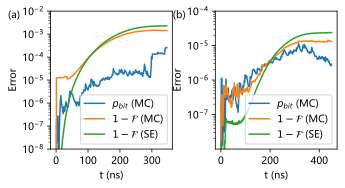

In [19]:
fig = plt.figure(figsize=(5, 2.5)) 
left = 0.15
subplot_width = 0.34
mid = 0.12
gs0 = fig.add_gridspec(nrows=1, ncols=1,left=left, right=left+subplot_width,bottom=0.2,top = 0.97)
gs1 = fig.add_gridspec(nrows=1, ncols=1,left=left+subplot_width+mid, right=left+subplot_width+subplot_width+mid,bottom=0.2,top = 0.97)
axes = [fig.add_subplot(gs0[0]),  fig.add_subplot(gs1[0])]

from matplotlib.ticker import LogLocator


# ef
max_ql = 20
max_ol = 300
tot_time =400
tlist = np.linspace(0, tot_time, tot_time)
last_t_idx = 346
t_indices = [0, 70, 140, 210, 280, 346]
with open('ef_leakage.pkl', 'rb') as f:
    leakage_arr = pickle.load(f)
axes[0].plot(tlist[:last_t_idx+1], ((np.array(leakage_arr[0])+np.array(leakage_arr[2]))/2)[:last_t_idx+1],label=rf'$p_{{bit}}$ (MC)' )
with open('ef_mcsolve_infidelity_new.pkl', 'rb') as f:
    infidelity = pickle.load(f)
axes[0].plot(tlist[:last_t_idx+1], infidelity[:last_t_idx+1],label=rf'$1-\mathcal{{F}}$ (MC)' )
with open('../ef_larger_drive/sesolve_large_dim_a015_tomo_infidelity.pkl', 'rb') as f:
    infidelity = pickle.load(f)
axes[0].set_ylabel('Error')
axes[0].plot(tlist[:last_t_idx+1], infidelity[:last_t_idx+1],label=rf'$1-\mathcal{{F}}$ (SE)' )
axes[0].legend()
axes[0].set_yscale('log')
axes[0].set_xlabel('t (ns)')
axes[0].set_ylim(1e-8,1e-2)
axes[0].set_yticks([1e-8,1e-7,1e-6,1e-5,1e-4,1e-3,1e-2])
axes[0].tick_params(axis='x', which='minor', bottom=False)
axes[0].yaxis.set_minor_locator(LogLocator(base=10.0, subs='auto', numticks=10))
# gf
max_ql = 25
max_ol = 200
tot_time =500
tlist = np.linspace(0, tot_time, tot_time)
last_t_idx = 449
t_indices = [0, 90, 180, 270, 360, 449]
with open('gf_bit.pkl', 'rb') as f:
    bitflip_arr = pickle.load(f)
axes[1].plot(tlist[:last_t_idx+1], ((np.array(bitflip_arr[0])+np.array(bitflip_arr[1]))/2)[:last_t_idx+1],label=rf'$p_{{bit}}$ (MC)' )
with open('gf_mcsolve_infidelity_three_lvl.pkl', 'rb') as f:
    infidelity = pickle.load(f)
axes[1].plot(tlist[:last_t_idx+1], infidelity[:last_t_idx+1],label=rf'$1-\mathcal{{F}}$ (MC)' )
with open('../gf_new/sesolve_large_dim_a015_tomo_infidelity.pkl', 'rb') as f:
    infidelity = pickle.load(f)
axes[1].set_ylabel('Error')
axes[1].plot(tlist[:last_t_idx+1], infidelity[:last_t_idx+1],label=rf'$1-\mathcal{{F}}$ (SE)' )
axes[1].legend()
axes[1].set_yscale('log')
axes[1].set_ylim(1e-8,1e-4)
axes[1].set_yticks([1e-7,1e-6,1e-5,1e-4])
axes[1].set_xlabel('t (ns)')

axes[0].text(-0.35, 0.95, '(a)', transform=axes[0].transAxes)
axes[1].text(-0.35, 0.95, '(b)', transform=axes[1].transAxes)


fig.savefig('fidelity.pdf')